# Food Image Classification for the course _Foundations of Deep Learning_.

Professors:
Paolo Napoletano
Marco Buzzelli

Tutor:
Mirko Agarla

## Notebook for Data preprocessing and Data Augmentation

In [1]:
!pip install split-folders # install the package to split the images in TRAIN and TEST folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# IMPORT MODULES
import os

import fnmatch # to count number of image per folder easily
import random # to select random images from a folder
import numpy as np
import pandas as pd
import splitfolders # needed to split the images in TRAIN and TEST folders
from os import mkdir
from shutil import copyfile # to import "copyfile"
# from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from collections import defaultdict

# CV2
import cv2
from google.colab.patches import cv2_imshow 

In [3]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# IMPORT UTILS.PY

# 1.Insert the directory
import sys
sys.path.insert(0,"/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food")

# 2.Import your module or file
import utils
from utils import *

To pay attention when importing custom modules:

- https://stackoverflow.com/questions/62042811/what-is-the-correct-way-to-import-modules-when-im-writing-my-own-module-in-pyth

In [5]:
# CONSTANT
# SCALE_PERCENT = 6 # resizing percentage
SEED_VALUE = 42
num_classes = 10 # number of output classes

# PATH TO THE DATA
ORIGINAL_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset"
PREPROCESSED_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed"
DIR_TRAIN_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test' # path contenente i sottoinsiemi di train, test

# 1.Loading the dataset and Data Exploration
In this section we will describe the data at hand.

> ## Exploratory Data Analysis (EDA)

In [6]:
# HOW MANY FOLDERS (CLASSES) DO WE HAVE? WHICH CLASSES DO WE HAVE?
lst = os.listdir(ORIGINAL_DATA) # your directory path
file_names = lst
number_files = len(file_names)
print("Class names:", file_names)
print("Number of classes: ", number_files)

Class names: ['french_fries', 'caprese_salad', 'pizza', 'greek_salad', 'sashimi', 'hot_dog', 'caesar_salad', 'hamburger', 'sushi', 'rejection_class']
Number of classes:  10


In [7]:
# COUNT THE NUMBER OF ELEMENTS IN EACH CLASS FOLDERS

# FOLDER PATH
count = 0
hist_dict = {}

# ITERATE DIRECTORY
for path in os.listdir(ORIGINAL_DATA):
    # CHECK IF CURRENT PATH IS A FILE
    if os.path.isfile(os.path.join(ORIGINAL_DATA, path)):
      count += 0
    else:
      # IF IS NOT A FILE, IS A DIRECTORY. GET THE FOLDER NAME
      number_of_elements_per_folder = len([entry for entry in os.listdir(ORIGINAL_DATA + "/" + path)])
      print(f"The folder called {path} has a number of element(s) equal to:", number_of_elements_per_folder)
      count += 1
      hist_dict[path] = number_of_elements_per_folder

print()
print('Number of folders:', count, "different classes of food.")

The folder called french_fries has a number of element(s) equal to: 181
The folder called caprese_salad has a number of element(s) equal to: 15
The folder called pizza has a number of element(s) equal to: 299
The folder called greek_salad has a number of element(s) equal to: 24
The folder called sashimi has a number of element(s) equal to: 40
The folder called hot_dog has a number of element(s) equal to: 31
The folder called caesar_salad has a number of element(s) equal to: 27
The folder called hamburger has a number of element(s) equal to: 238
The folder called sushi has a number of element(s) equal to: 124
The folder called rejection_class has a number of element(s) equal to: 254

Number of folders: 10 different classes of food.


In [8]:
# SHOW A DATAFRAME OF THE DICTIONARY CONTAINING CLASSES AND COUNT OF CLASSES
pd.DataFrame.from_dict([hist_dict]).T.sort_values(by=0, ascending=False).rename(columns={0: "count"}).reset_index().rename(columns={"index": "classes"})

,classes,count
0,pizza,299
1,rejection_class,254
2,hamburger,238
3,french_fries,181
4,sushi,124
5,sashimi,40
6,hot_dog,31
7,caesar_salad,27
8,greek_salad,24
9,caprese_salad,15


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

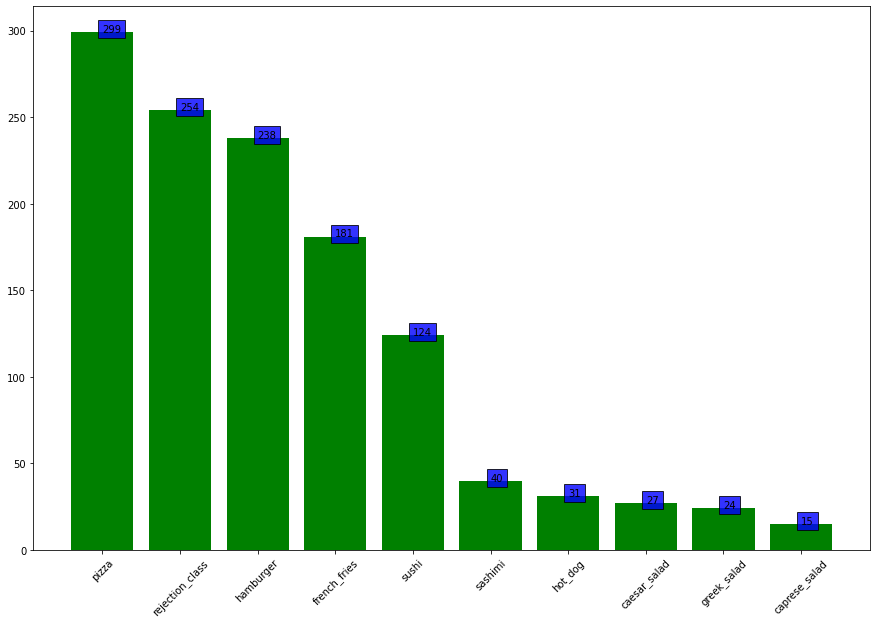

In [9]:
# SHOW THE DATASET DISTRIBUTION WITH A HISTOGRAM PLOT
plt.figure(figsize=(15, 10))

# CONVERT THE DICT TO DATAFRAME
new = pd.DataFrame([hist_dict]).transpose().reset_index()
new = new.rename(columns={"index": "food_name", 0: "value_count"})
# SORT THE DATAFRAME BASED ON VALUE_COUNT
new = new.sort_values("value_count", ascending=False)

# # CREATING DATA ON WHICH BAR CHART WILL BE PLOT
x_food_name = list(new['food_name'])
y_value_count = list(new['value_count'])

plt.bar(new['food_name'], new['value_count'], color='g')
# # CALLING THE FUNCTION TO ADD VALUE LABELS
utils.addlabels(x_food_name, y_value_count)
plt.xticks(rotation=45)

It is clear that this dataset shows an _unbalanced class problem_ that needs to be addressed through _data augmentation_.

## Show some images as example, their original sizes and the format

As it is visible from the image shape, they are of different sizes but all of them contain the full RGB color spectrum. In order to correctly treat them and feed them inside the CNN it is important that a preprocessing step of resizing them will be applied.



> ### DISPLAY SEVERAL IMAGES AT ONCE
Pick some of the images randomly from the dataset, and show them.


The image corresponding to french_fries has the shape of: (808, 1078, 3)
The image corresponding to caprese_salad has the shape of: (1078, 808, 3)
The image corresponding to pizza has the shape of: (756, 1008, 3)
The image corresponding to greek_salad has the shape of: (509, 745, 3)
The image corresponding to sashimi has the shape of: (696, 468, 3)
The image corresponding to hot_dog has the shape of: (525, 1359, 3)
The image corresponding to caesar_salad has the shape of: (808, 1078, 3)
The image corresponding to hamburger has the shape of: (625, 607, 3)
The image corresponding to sushi has the shape of: (227, 655, 3)
The image corresponding to rejection_class has the shape of: (426, 800, 3)


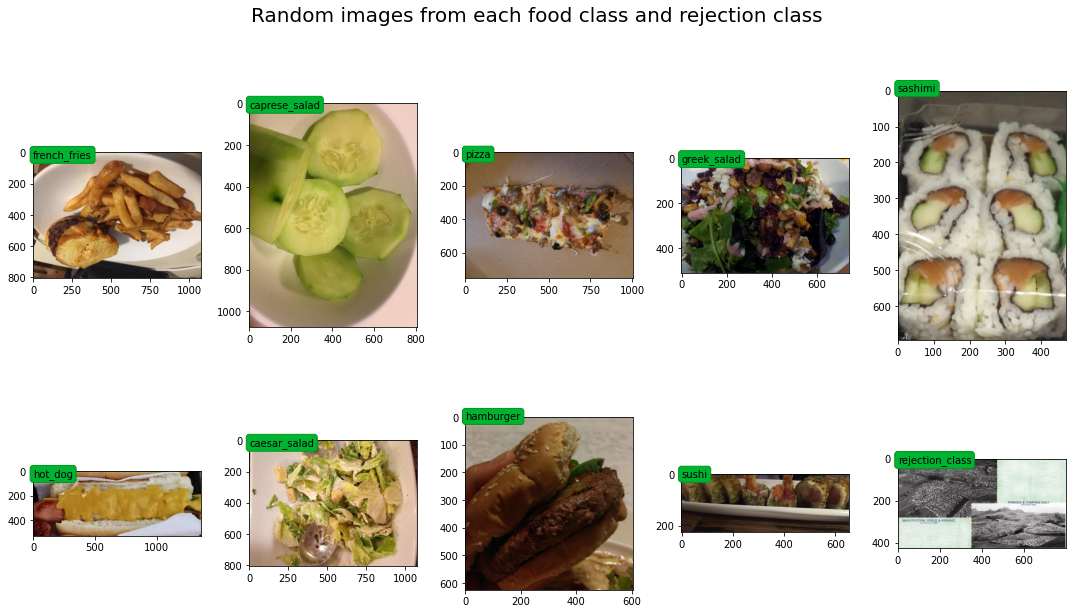

In [10]:
# DECIDE THE NUMBER OF IMAGES PER ROW AND COLUMN TO SHOW
rows = 2
cols = 5

# DEFINE SUBPLOTS BASED ON ROWS AND COLUMNS AND FIGSIZE
fig, ax = plt.subplots(rows, cols, figsize=(15, 10)) # fig = relative to the figure; ax = relative to the axes.
# ADD A TITLE
fig.suptitle('Random images from each food class and rejection class', fontsize=20)

# CREATE AN EMPTY LIST IN ORDER TO ADD ONLY THE DIRECTORY AND NOT THE FILES
food_dirs = []

# FOR EACH FILE IN ORIGINAL_DATA, CHECK IF IT IS A DIRECTORY AND, IF YES, ADD IT TO THE FOOD_DIRS FOLDER
for filename in os.listdir(ORIGINAL_DATA):
    if os.path.isdir(os.path.join(ORIGINAL_DATA,filename)):
        food_dirs.append(filename)

# PRINT THE FINAL LIST
# print(food_dirs)

# SHOW SOME RANDOM IMAGES FROM THE FOLDERS
for i in range(rows):
    for j in range(cols):
      food_dir = food_dirs[i*cols + j]
      all_files = os.listdir(os.path.join(ORIGINAL_DATA, food_dir))
      rand_img = np.random.choice(all_files)
      img = plt.imread(os.path.join(ORIGINAL_DATA, food_dir, rand_img))
      ax[i][j].imshow(img)
      
      # CREATE COLORS FOR THE BOX AROUND THE TEXT
      ec = (0, .6, .1)
      fc = (0, .7, .2)
      # CREATE THE TEXT ON TOP OF THE IMAGE
      ax[i][j].text(0, -20, food_dir, size=10, rotation=0, ha="left", va="top", 
              bbox=dict(boxstyle="round", ec=ec, fc=fc))
      print(f"The image corresponding to {food_dir} has the shape of:", img.shape)
        
# plt.setp(ax, xticks=[], yticks=[]) # do not show the ticks
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

As it is visible from the image shape, they are of different sizes but all of them contain the full RGB color spectrum. In order to correctly treat them and feed them inside the CNN it is important that a preprocessing step of resizing them will be applied.

# 3.DATA PREPROCESSING

## Resize all the images

When using the ImageDataGenerator method in keras, the use target_size is used for resizing the images before feed them to the model. So, it is not necessary to resize them in advance.

In [11]:
# CREATE AN EMPTY LIST TO FILL WITH THE CATEGORIES
CATEGORIES = []

# LOOP THROUGH THE ROOT DIRECTORY, SELECT ONLY THE DIRECTORIES AND SAVE THEIR NAME
for filename in os.listdir(ORIGINAL_DATA):
    if os.path.isdir(os.path.join(ORIGINAL_DATA,filename)):
        CATEGORIES.append(filename)

# SHOW THE CATEGORY NAMES
CATEGORIES

['french_fries',
 'caprese_salad',
 'pizza',
 'greek_salad',
 'sashimi',
 'hot_dog',
 'caesar_salad',
 'hamburger',
 'sushi',
 'rejection_class']

In [12]:
# DELETE THE FOLDER EXAMPLEFOODIMAGEDATASETPREPROCESSED
# !rm -rf "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed"

In [13]:
# CREATE A DIRECTORY FOR THE PROCESSED IMAGES
try:
    os.mkdir(PREPROCESSED_DATA)
except:
    print("Folder already found.")

In [14]:
# RESIZE THE IMAGES AND SAVE THEM

# CREATE LISTS TO STORE THE IMAGE SIZE
image_size = {}
img_width_list = list()
img_height_list = list()

for i in CATEGORIES:
    # print(f'CATEGORY: {i}')
    # CREATE A DIRECTORY FOR THE PROCESSED IMAGES
    
    try:
        os.mkdir(os.path.join(PREPROCESSED_DATA,i))
    except:
        print("Folder already found.")
        # pass

    path = os.path.join(ORIGINAL_DATA,i)
    
    for img in os.listdir(path):
      if img.endswith(('.png', '.jpg', '.jpeg')):
        img_raw = cv2.imread(os.path.join(ORIGINAL_DATA, i, img))

        ################################################################################
        ################################################################################
        ################################################################################
        # QUESTO SAREBBE DA NORMALIZZARLI TRA -1 ED 1 VOLENDO POI APPLICARCI MOBILENETV2
        
        # img_raw = cv2.normalize(img_raw, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

        # YOU SHOULD USE THIS:
        # img_raw = cv2.normalize(img_raw, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX) # ,dtype=cv2.CV_32F
        ################################################################################
        ################################################################################
        ################################################################################
        
        
        img_width, img_height, img_channel = img_raw.shape # get the size of the image

        ##################################################################

        # STORE THE WIDTH
        img_width_list.append(img_width)
        img_width_set = set(img_width_list)

        # STORE THE HEIGHT
        img_height_list.append(img_height)
        img_height_set = set(img_height_list)

        ##################################################################

        # CHECK IF IMG_WIDTH IS IN THE DICTIONARY. IF NOT ADD IT; IF YES +1
        if img_width in image_size:
            image_size[img_width] += 1
        else:
            image_size[img_width] = 1

        # CHECK IF IMG_WIDTH IS IN THE DICTIONARY. IF NOT ADD IT; IF YES +1
        if img_height in image_size:
            image_size[img_height] += 1
        else:
            image_size[img_height] = 1
      else:
        continue

      # RESIZING WITH FIXED VALUES
      # width1 = int(img_raw.shape[1] * SCALE_PERCENT / 100)
      # height1 = int(img_raw.shape[0] * SCALE_PERCENT / 100)
      width1 = 224
      height1 = 224
      dim1 = (width1, height1)
      img_resized = cv2.resize(img_raw, dim1, interpolation = cv2.INTER_AREA)

      # SAVING THE IMAGES
      cv2.imwrite(os.path.join(PREPROCESSED_DATA, i, f"{img}_RESIZED.jpg"), img_resized)

      # Save Image
      print('Saving the image...')

Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...
Saving the image...


In [15]:
# GET THE MINIMUM OF WIDTH
print("Minimum of image width: ", min(set(img_width_list)))

# GET THE MAXIMUM OF WIDTH
print("Maximum of image width: ", max(set(img_width_list)))
print()
# GET THE MINIMUM OF HEIGHT
print("Minimum of image height: ", min(set(img_height_list)))

# GET THE MAXIMUM OF HEIGHT
print("Maximum of image height: ", max(set(img_height_list)))

Minimum of image width:  64
Maximum of image width:  7813

Minimum of image height:  59
Maximum of image height:  14090


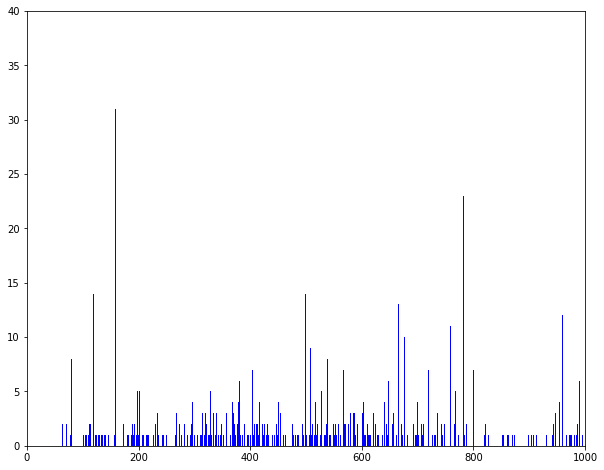

In [16]:
# PLOT AN HISTOGRAM OF IMAGE SIZES
plt.figure(figsize=(10,8))
plt.bar(list(image_size.keys()), image_size.values(), color='b')
plt.xlim((0,1000))
plt.ylim((0,40))
plt.show()

## Data Splitting

In [17]:
# DELETE THE FOLDER TRAIN-TEST-VAL DATA FOLDER
!rm -rf "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test"

In [18]:
# CREATE A DIRECTORY FOR THE SPLITTING
try:
    os.mkdir(DIR_TRAIN_TEST_DATA)
except:
    print("Folder already found.")

In [19]:
# SPLIT THE IMAGE IN TRAIN AND TEST SETS. 65% TRAIN DATA AND 35% TEST DATA.
splitfolders.ratio(PREPROCESSED_DATA,
                   output= DIR_TRAIN_TEST_DATA,
                   seed = SEED_VALUE,
                   ratio = (.65, .20, .15)) # training, validation, testing

Copying files: 1228 files [00:19, 61.92 files/s]


# 4.Data Augmentation on the train set

In this section we will apply different techniques in order to create additional images to be fed, later, into the model.

Why _Data Augmentation_ is important?

Data augmentation is a technique used to artificially increase the size of a dataset by generating modified versions of existing data. In the field of machine learning and deep learning, this is often done to improve the performance of a model by providing it with more diverse data to learn from.

In this scenario, the reasons behind applying _data augmentation_ are multiple ones:

1. **Limited data**: because we are creating an Image Classification problem in Deep Learning we should try to have as much images as possible in order to correctly train our Deep Leearning architecture.

2. **Overfitting**: because our goal is to generalize the model to new data, we want to avoid overfitting by feeding our model with as much data as possible in order to be able to not learn features only for the specific dataset that we are dealing with. Data augmentation can help by generating data that is similar to the original data, but with small variations, which can reduce overfitting.

3. **Regularization**: another way of increasing the performance of our model, is using Data Augmentation as a form of regularization. We are adding noise to the training data and forcing the model to learn more robust features; therefore, this can help to prevent overfitting and improve the generalization of the model.

In [20]:
# CHECK AGAIN THE NUMBER OF IMAGES FOR EACH CLASSES
# COUNT THE NUMBER OF ELEMENTS IN EACH CLASS FOLDERS

# COUNT IMAGES AND CREATE A DICT
count_processed = 0
hist_dict_processed = {}

# ITERATE DIRECTORY
for path in os.listdir(DIR_TRAIN_TEST_DATA):
  if path == "train":

    print(path)
    for categories in os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path)):
      print("--", categories)

      for images in os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)):

        # CHECK IF CURRENT PATH IS A FILE
        if os.path.isfile(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)):
          count_processed += 0
        else:
          # IF IS NOT A FILE, IS A DIRECTORY. GET THE FOLDER NAME
          number_of_elements_per_folder = len([entry for entry in os.listdir(DIR_TRAIN_TEST_DATA + "/" + path + "/" + categories)])
          # print(f"The folder called {path} has a number of element(s) equal to:", number_of_elements_per_folder)
          count_processed += 1
          hist_dict_processed[categories] = number_of_elements_per_folder
  else:
    break

print()
# print('Number of folders:', count_processed, "different classes of food.")

train
-- french_fries
-- caprese_salad
-- pizza
-- greek_salad
-- sashimi
-- hot_dog
-- caesar_salad
-- hamburger
-- sushi
-- rejection_class



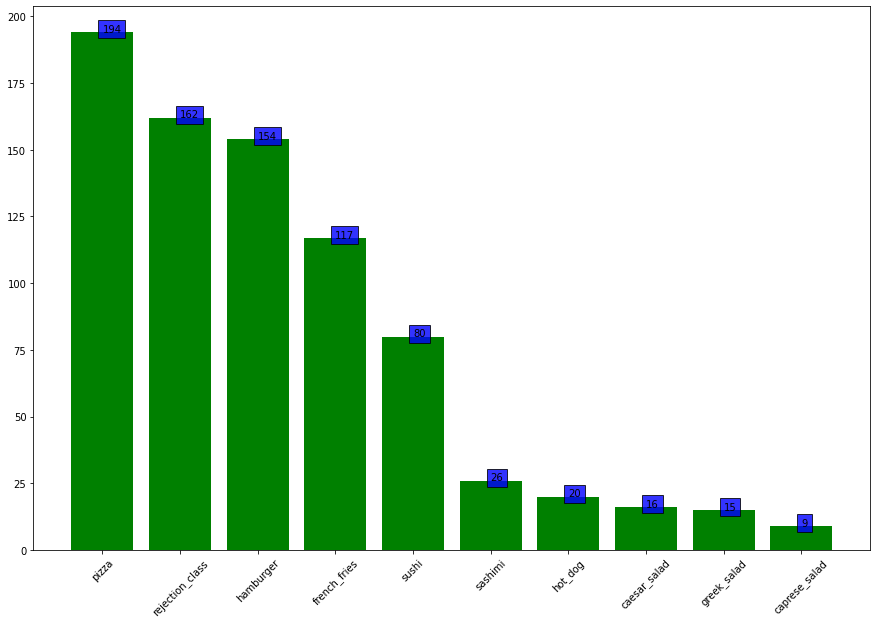

In [21]:
# SHOW THE DATASET DISTRIBUTION WITH A HISTOGRAM PLOT ONLY FOR THE TRAINING SET
plt.figure(figsize=(15, 10))

# CONVERT THE DICT TO DATAFRAME
new_processed = pd.DataFrame([hist_dict_processed]).transpose().reset_index()
new_processed = new_processed.rename(columns={"index": "food_name", 0: "value_count"})

# SORT THE DATAFRAME BASED ON VALUE_COUNT
new_processed = new_processed.sort_values("value_count", ascending=False)
new_processed

# PLOT THE BAR AND THE TICKS
plt.bar(new_processed['food_name'], new_processed['value_count'], color='g')
plt.xticks(rotation=45)

# CREATING DATA ON WHICH BAR CHART WILL BE PLOT
x_food_name = list(new_processed['food_name'])
y_value_count = list(new_processed['value_count'])

# CALLING THE FUNCTION TO ADD VALUE LABELS
utils.addlabels(x_food_name, y_value_count)

It is still visible that the training set has imbalance classes, a problem that has to be faced before creating the Convolutional Neural Network model.

In [22]:
# DATA AUGMENTATION

# COUNT IMAGES AND CREATE A DICT
count_images = 0

# ITERATE IN THE DIRECTORY
for path in os.listdir(DIR_TRAIN_TEST_DATA):
  if path == "train":

    print(path)
    for categories in os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path)):
      print("--", categories)
      # USE https://docs.python.org/3/library/fnmatch.html TO CHECK THE SIZE OF EACH FOLDER
      category_size = len(fnmatch.filter(os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)), '*.jpg'))

      # If the number of images is 200, stop the while loop
      max_number_of_images = 200
      while category_size < max_number_of_images:
        

        # PATH TO THE IMAGES
        category_path_folder = fnmatch.filter(os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)), '*.jpg')
        # print(DIR_TRAIN_TEST_DATA)

        # LOAD A RANDOM IMAGE AND READ IT
        random_image = random.choice(category_path_folder)
        image = cv2.imread(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, random_image))

        # PERFORM DATA AUGMENTATION
        # -------------------------
        # HORIZONTAL FLIP
        img_horiz_flipped = utils.horizontal_flip(image, True)
        # VERTICAL FLIP
        img_vertical_flipped = utils.vertical_flip(image, True)
        # BRIGHTNESS
        img_brightness = utils.brightness(image, 0.5, 1.3)
        # CHANNEL SHIFT
        img_hue_image = utils.hue_image(image, 5)
        
        # SHOW THE IMAGE
        # cv2_imshow(img_horiz_flipped)

        # SAVING THE IMAGES
        cv2.imwrite(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, f"{random_image}_horiz_flipped.jpg"), img_horiz_flipped)
        cv2.imwrite(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, f"{random_image}_vertical_flipped.jpg"), img_vertical_flipped)
        cv2.imwrite(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, f"{random_image}_vertical_flipped.jpg"), img_brightness)
        cv2.imwrite(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, f"{random_image}_vertical_flipped.jpg"), img_hue_image)
        # print(os.path.join(DIR_TRAIN_TEST_DATA, path, categories, f"{random_image}_horiz_flipped.jpg"), img_horiz_flipped)

        # WHAT IS THE CURRENT SIZE OF THE FOLDER?
        category_size = len(fnmatch.filter(os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)), '*.jpg'))
        print(f"Category size is (continue until reached {max_number_of_images} images in each folder):", category_size)

      else:
        # EXIT FROM THIS CATEGORY DIRECTORY IF THE NUMBER OF IMAGES INSIDE IS MORE THAN max_number_of_images
        continue

  else:
    break

train
-- french_fries
Category size is (continue until reached 200 images in each folder): 119
Category size is (continue until reached 200 images in each folder): 121
Category size is (continue until reached 200 images in each folder): 123
Category size is (continue until reached 200 images in each folder): 125
Category size is (continue until reached 200 images in each folder): 127
Category size is (continue until reached 200 images in each folder): 129
Category size is (continue until reached 200 images in each folder): 131
Category size is (continue until reached 200 images in each folder): 133
Category size is (continue until reached 200 images in each folder): 135
Category size is (continue until reached 200 images in each folder): 137
Category size is (continue until reached 200 images in each folder): 139
Category size is (continue until reached 200 images in each folder): 141
Category size is (continue until reached 200 images in each folder): 143
Category size is (continue un

Now we are going to check the size of each folder.

In [23]:
# CHECK SIZE OF FOLDERS
print("Size of the folder caesar_salad: ",  len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/caesar_salad"), '*.jpg')))
print("Size of the folder caprese_salad: ", len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/caprese_salad"), '*.jpg')))
print("Size of the folder french_fries: ",  len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/french_fries"), '*.jpg')))
print("Size of the folder greek_salad: ",   len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/greek_salad"), '*.jpg')))
print("Size of the folder hamburger: ",     len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/hamburger"), '*.jpg')))
print("Size of the folder hot_dog: ",     len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/hot_dog"), '*.jpg')))
print("Size of the folder pizza: ",     len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/pizza"), '*.jpg')))
print("Size of the folder sashimi: ",     len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/sashimi"), '*.jpg')))
print("Size of the folder sushi: ",     len(fnmatch.filter(os.listdir("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/sushi"), '*.jpg')))

Size of the folder caesar_salad:  200
Size of the folder caprese_salad:  201
Size of the folder french_fries:  201
Size of the folder greek_salad:  201
Size of the folder hamburger:  200
Size of the folder hot_dog:  200
Size of the folder pizza:  200
Size of the folder sashimi:  200
Size of the folder sushi:  200


In [24]:
# CHECK AGAIN THE NUMBER OF IMAGES FOR EACH CLASSES
# COUNT THE NUMBER OF ELEMENTS IN EACH CLASS FOLDERS

# COUNT IMAGES AND CREATE A DICT
count_processed = 0
hist_dict_processed = {}

# ITERATE DIRECTORY
for path in os.listdir(DIR_TRAIN_TEST_DATA):
  if path == "train":

    print(path)
    for categories in os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path)):
      print("--", categories)

      for images in os.listdir(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)):

        # CHECK IF CURRENT PATH IS A FILE
        if os.path.isfile(os.path.join(DIR_TRAIN_TEST_DATA, path, categories)):
          count_processed += 0
        else:
          # IF IS NOT A FILE, IS A DIRECTORY. GET THE FOLDER NAME
          number_of_elements_per_folder = len([entry for entry in os.listdir(DIR_TRAIN_TEST_DATA + "/" + path + "/" + categories)])
          # print(f"The folder called {path} has a number of element(s) equal to:", number_of_elements_per_folder)
          count_processed += 1
          hist_dict_processed[categories] = number_of_elements_per_folder
  else:
    break

print()
# print('Number of folders:', count_processed, "different classes of food.")

train
-- french_fries
-- caprese_salad
-- pizza
-- greek_salad
-- sashimi
-- hot_dog
-- caesar_salad
-- hamburger
-- sushi
-- rejection_class



Show a histogram of the number of element for each categories.

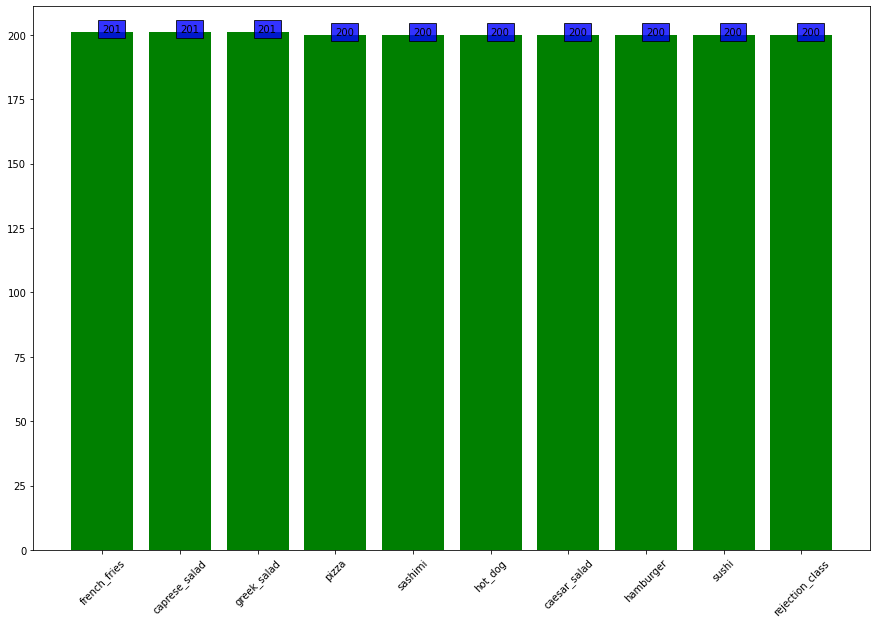

In [25]:
# SHOW THE DATASET DISTRIBUTION WITH A HISTOGRAM PLOT ONLY FOR THE TRAINING SET
plt.figure(figsize=(15, 10))

# CONVERT THE DICT TO DATAFRAME
new_processed = pd.DataFrame([hist_dict_processed]).transpose().reset_index()
new_processed = new_processed.rename(columns={"index": "food_name", 0: "value_count"})

# SORT THE DATAFRAME BASED ON VALUE_COUNT
new_processed = new_processed.sort_values("value_count", ascending=False)
new_processed

# PLOT THE BAR AND THE TICKS
plt.bar(new_processed['food_name'], new_processed['value_count'], color='g')
plt.xticks(rotation=45)

# CREATING DATA ON WHICH BAR CHART WILL BE PLOT
x_food_name = list(new_processed['food_name'])
y_value_count = list(new_processed['value_count'])

# CALLING THE FUNCTION TO ADD VALUE LABELS
utils.addlabels(x_food_name, y_value_count)

### Now all the folders present a number of elements of 300 elements, solving the class unbalanced problem.

### Example of augmented images: in order to demonstrate how the data augmentation works, the following picture shows the application of brightness to a single image before applying it to multiple images in the dataset.

In [26]:
# SHOW THE SIZE OF THE IMAGE: THE IMAGE HAS BEEN RESIZED
french_fries_shape = cv2.imread("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed/french_fries/20160725_123734.jpg_RESIZED.jpg")
print("Shape of the image:", french_fries_shape.shape)

Shape of the image: (224, 224, 3)


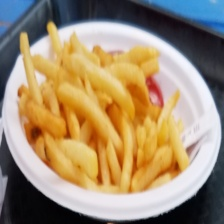

In [27]:
cv2_imshow(french_fries_shape)

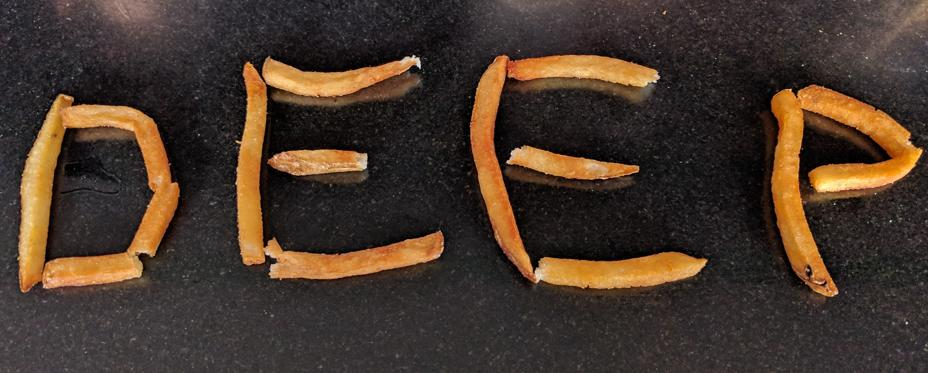

In [28]:
french_fries_brightness = cv2.imread("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/french_fries/cropfries46.jpg")
cv2_imshow(french_fries_brightness)

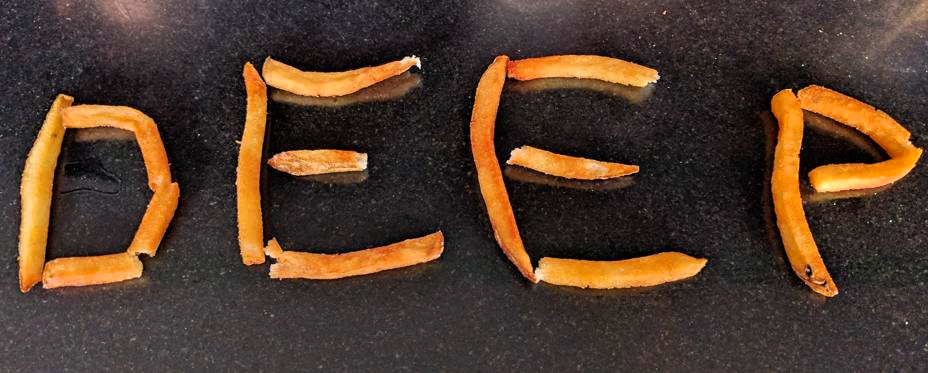

In [29]:
# THE BRIGHTNESS FUNCTION RELIES ON A RANDOM CHOICE OF THE LOW AND HIGH VALUES.
# THEREFORE, EACH ITERATION CAN BE DIFFERENT FROM THE PREVIOUS ONE.
img_brightness = utils.brightness(french_fries_brightness, 0.5, 1.3)
cv2_imshow(img_brightness)

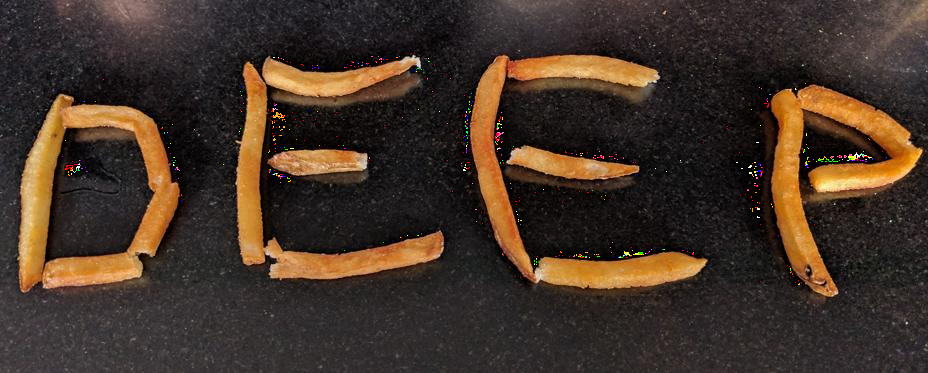

In [30]:
img_hue_image = utils.hue_image(french_fries_brightness, 5)
cv2_imshow(img_hue_image)

<Figure size 720x576 with 0 Axes>

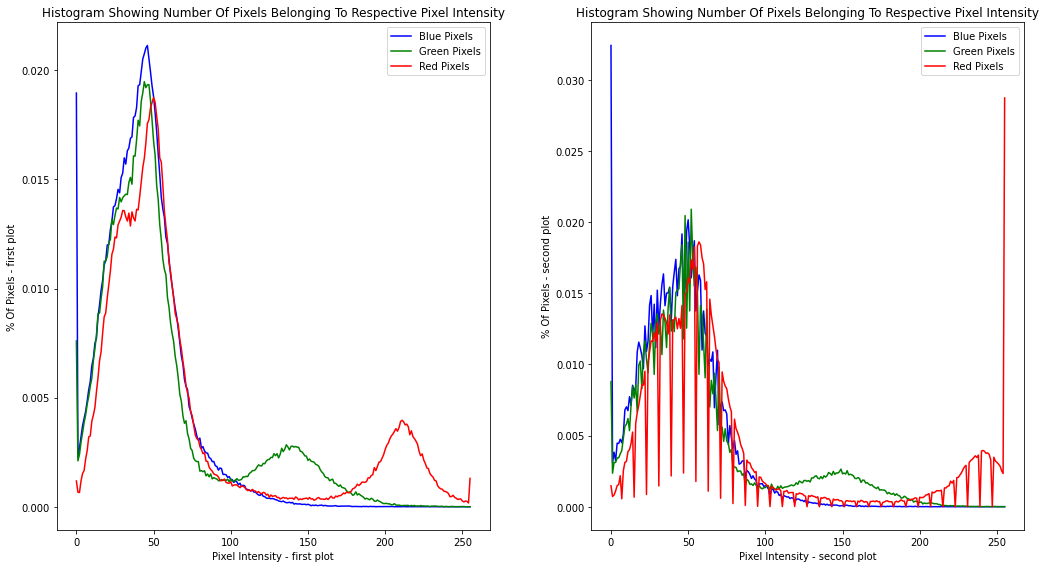

In [31]:
# SHOW THE RGB HISTOGRAM

# SET THE SIZE OF THE PICTURE
plt.figure(figsize=(10, 8)) 

# SETTING VALUES TO ROWS, COLUMN AND COLOR VARIABLE
# rows = 2
# columns = 2
colors = ('blue','green','red')
label = ("Blue", "Green", "Red")

# the container holding the two Axes have already been unpacked
# useful if just few Axes have been created
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8)) 

# FIRST PLOT ON THE LEFT
for count,color in enumerate(colors):
    histogram = cv2.calcHist(images = [french_fries_brightness], channels = [count], mask = None, histSize = [256], ranges = [0,256])
    # NORMALIZE IT
    histogram /= histogram.sum()
    ax1.plot(histogram,color = color, label=label[count]+str(" Pixels"))

ax1.set_title('Histogram Showing Number Of Pixels Belonging To Respective Pixel Intensity')
ax1.set_xlabel('Pixel Intensity - first plot')
ax1.set_ylabel('% Of Pixels - first plot')
ax1.legend(numpoints = 1, loc = "best")

for count,color in enumerate(colors):
    histogram = cv2.calcHist(images = [img_brightness], channels = [count], mask = None, histSize = [256], ranges = [0,256])
    # NORMALIZE IT
    histogram /= histogram.sum()
    ax2.plot(histogram,color = color, label=label[count]+str(" Pixels"))

ax2.set_title('Histogram Showing Number Of Pixels Belonging To Respective Pixel Intensity')
ax2.set_xlabel('Pixel Intensity - second plot')
ax2.set_ylabel('% Of Pixels - second plot')
ax2.legend(numpoints = 1, loc = "best")

plt.tight_layout()
plt.show()

# **DESCRIPTION TO MODIFY BASED ON THE NEW PLOT**

A histogram represents the distribution of pixel intensities (whether color or grayscale) in an image. It can be visualized as a graph (or plot) that gives a high-level intuition of the intensity (pixel value) distribution. We are going to assume a RGB color space in this example, so these pixel values will be in the range of 0 to 255.
Each of the red, green and blue light levels is encoded as a number in the range 0.. 255, with 0 meaning zero light and 255 meaning maximum light. So for example (red=255, green=100, blue=0) is a color where red is maximum, green is medium, and blue is not present at all, resulting in a shade of orange.

Furthermore, the bins (0-255) are plotted on the x-axis. And the y-axis counts the number of pixels in each bin.

The majority of the pixels fall in the range of roughly 5 to 60: this implies that there are a lot of "black" and very few "white" pixels in the image.
In the right figure we can see that a bigger amount of darker pixel are created, so we can say that the brightness function created a darker image than the original one.

------------------------------